# Report03 - 服装分类

* 沈键
* 2021200082

## 1. 任务简介

&ensp;&ensp;&ensp;&ensp;FashionMNIST 是一个替代 MNIST 手写数字集的图像数据集。 它是由 Zalando（一家德国的时尚科技公司）旗下的研究部门提供。其涵盖了来自 10 种类别的共 7 万个不同商品的正面图片。FashionMNIST 的大小、格式和训练集/测试集划分与原始的 MNIST 完全一致。60000/10000 的训练测试数据划分，28x28 的灰度图片。可以直接用它来测试机器学习和深度学习算法性能，且不需要改动任何的代码。

## 2. 数据分析

先来下载FashionMNIST数据集：

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
train_ds = torchvision.datasets.FashionMNIST(root='data/', train=True, download=True,
                                             transform=transforms.ToTensor())
val_ds   = torchvision.datasets.FashionMNIST(root='data/', train=False, download=True,
                                             transform=transforms.ToTensor())

FashionMNIST数据集大致如下（每个类别占三行）：

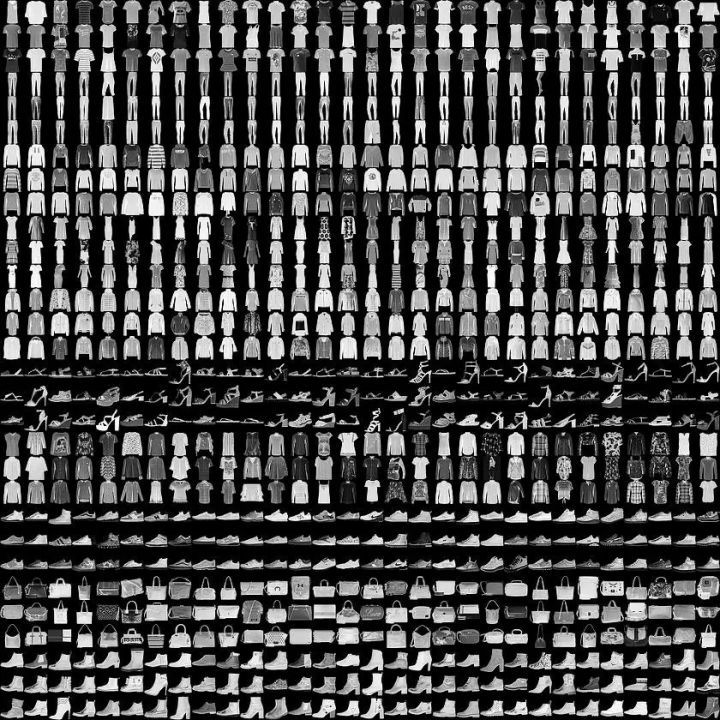

可以看到，FashionMNIST总共有10个类别，不同标签与类别的映射关系如下：

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

取出一张图来：

image.shape: torch.Size([1, 28, 28])
Label: 9


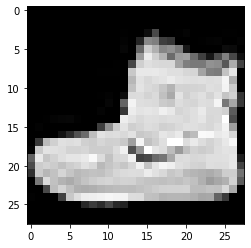

In [3]:
import matplotlib.pyplot as plt

image, label = train_ds[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

In [4]:
print(image[0, 10:15 , 10:15])
print(torch.max(image), torch.min(image))

tensor([[0.0000, 0.0000, 0.0000, 0.7569, 0.8941],
        [0.0118, 0.0000, 0.0471, 0.8588, 0.8627],
        [0.0235, 0.0000, 0.3882, 0.9569, 0.8706],
        [0.0000, 0.0000, 0.2157, 0.9255, 0.8941],
        [0.0000, 0.0000, 0.9294, 0.8863, 0.8510]])
tensor(1.) tensor(0.)


数据集中的每一张图为28x28大小的灰度图片，并且，灰度值已归一化，取值范围落在[0, 1]。这是一个多分类的图片识别问题，考虑使用卷积神经网络进行训练和识别。

## 3. 卷积神经网络

&ensp;&ensp;&ensp;&ensp;卷积神经网络与全连接神经网络很相似，依旧是层级网络，只是层的功能和形式做了变化，并多了许多传统神经网络没有的层次，例如卷积层、池化层。其结构示意图如下：

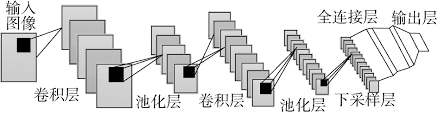

卷积网络也是收到了生物学的启发，一般人们认为图片中距离相近的部分相关性较大，而距离比较远的部分相关性较小，所以卷积网络使用了局部感受野，卷积层中的神经元连接不是全连接的，而是后一层的每个神经元连接前一层的一部分神经元，从而大大减少了参数量。

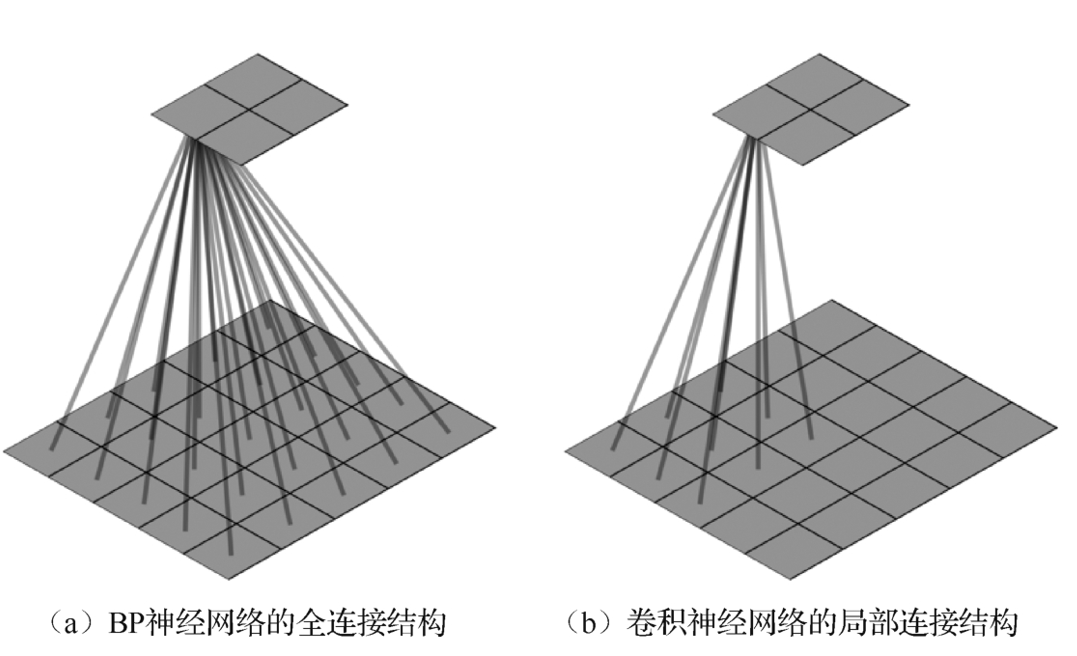

卷积核的另一个特点和优势时权值共享。卷积核的权重是经过学习得到的，并且在卷积过程中卷积核的权重是不会改变的，这就是参数共享的思想。权值共享降低了网络的复杂性，特别是多维输入向量的图像可以直接输入网络这一特点避免了特征提取和分类过程中数据重建的复杂度。

&ensp;&ensp;&ensp;&ensp;一个经典的卷积层包含3个部分——卷积计算、非线性激活函数和池化，池化也有一个滑动窗口，用于在图像中进行滑动计算，这一点跟卷积核有点类似，但池化层中没有需要训练的参数。卷积网络中的权值参数还是很多，池化层可对提取到的特征信息进行降维，一方面使特征图变小，简化网络计算复杂度并在一定程度上避免过拟合的出现；一方面进行特征压缩，提取主要特征。池化操作使得网络的输入具有平移不变特征。常用的池化函数有max-pooling和mean-pooling，max-pooling为取池化窗口中的最大值，mean-pooling取的是池化窗口中的平均值。

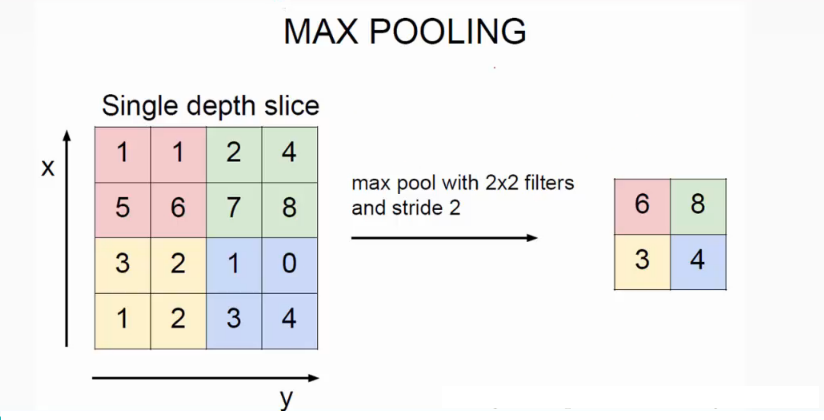

再经过几层卷积层后，特征图的尺寸越来越小，最后通过将特征图展平，后面部分进行全连接，对提取出来的图像特征进行分类。

&ensp;&ensp;&ensp;&ensp;在卷积网络的设计中，除了需要设计合适的深度外，还需要给定卷积核和池化窗口的尺寸大小和移动步长，并且，为了避免丢失图像的边缘特征，往往还需要对特征图进行Padding操作，即在图像的外缘填充数据，这样，可以使得卷积后得到的特征图的大小跟原始图像的大小相同。

## 4. 模型训练

&ensp;&ensp;&ensp;&ensp;在此次任务中，我们选取的卷积神经网络由2层卷积层和2层全连接层构成，池化函数选用的是最大池化，激活函数选用的为ReLUh函数。其代码如下：

In [5]:
import logging
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class Fashion_Model(nn.Module):
  def __init__(self, input_dim, num_classes):
    super().__init__()
    self.input_dim   = input_dim
    self.num_classes = num_classes

    self.network = nn.Sequential(
      nn.Conv2d(input_dim[0], 32, kernel_size=5, stride=1, padding='same'),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),

      nn.Conv2d(32, 64, kernel_size=5, stride=1, padding='same'),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),

      nn.Flatten(),
      nn.Linear(64*(input_dim[1]//4*input_dim[2]//4), 1024),
      nn.ReLU(),

      nn.Linear(1024, 10))

  def forward(self, inputs):
    outputs = self.network(inputs)
    return outputs

  @staticmethod
  def compute_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  @staticmethod
  def log_epoch_loss_and_acc(prefix, epoch, epoch_loss, epoch_acc, interval=5):
    if epoch % interval == 0:
      logging.info(f'{prefix}_Epoch [{epoch}], loss: {epoch_loss:.4f},'
                    f' acc: {epoch_acc:.4f}.')

  def evaluate(self, batch, loss_func, need_acc=False, no_grad=False):
    if no_grad:
      with torch.no_grad():
        inputs, labels = batch
        outputs = self(inputs)
        loss = loss_func(outputs, labels)
    else:
      inputs, labels = batch
      outputs = self(inputs)
      loss = loss_func(outputs, labels)

    if need_acc:
      acc  = self.compute_accuracy(outputs, labels)
      return {'loss': loss, 'acc': acc}
    else:
      return {'loss': loss}

  def compute_epoch_loss_and_acc(self, dataloader, loss_func):
    results = [self.evaluate(batch, loss_func, need_acc=True, no_grad=True)
                                    for batch in dataloader]
    batch_losses = [r['loss'] for r in results]
    epoch_loss   = torch.stack(batch_losses).mean()
    batch_accs   = [r['acc'] for r in results]
    epoch_acc    = torch.stack(batch_accs).mean()
    return {'epoch_loss': epoch_loss, 'epoch_acc': epoch_acc}

  def epoch_postprocess(self, prefix, data_loader, epoch,
                        history, loss_func, log_interval):
    loss_and_acc = self.compute_epoch_loss_and_acc(data_loader, loss_func)
    epoch_loss   = loss_and_acc['epoch_loss']
    epoch_acc    = loss_and_acc['epoch_acc']
    history.append({'epoch_loss': epoch_loss,
                    'epoch_acc': epoch_acc})
    self.log_epoch_loss_and_acc(prefix, epoch,
                                     epoch_loss,
                                     epoch_acc,
                                     log_interval)

  def train(self, train_loader, val_loader, num_epochs, lr,
            loss_func=F.cross_entropy, opt_func=torch.optim.Adam,
            log_interval=5):
    optimizer = opt_func(self.parameters(), lr)
    self.history_train = []  # history of train set
    self.history_val   = []  # history of validation set

    # initial loss and accuracy of training dataset
    self.epoch_postprocess('Train', train_loader, 0,
                           self.history_train, loss_func, log_interval)

    # initial loss and accuracy of validation dataset
    self.epoch_postprocess('Val', val_loader, 0,
                           self.history_val, loss_func, log_interval)

    # iteration
    for epoch in range(num_epochs):
      for batch in train_loader:
        loss = self.evaluate(batch, loss_func, need_acc=False)['loss']
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

      # training dataset loss and accuracy
      self.epoch_postprocess('Train', train_loader, epoch+1,
                             self.history_train, loss_func, log_interval)

      # validation dataset loss and accuracy
      self.epoch_postprocess('Val', val_loader, epoch+1,
                             self.history_val, loss_func, log_interval)

  def predict(self, inputs):
    outputs = self(inputs)
    _, preds = torch.max(outputs, dim=1)
    return [preds[i].item() for i in range(len(preds))]

  def save_model(self, save_file):
    torch.save(self.state_dict(), save_file)
    pickle.dump(self.history_train, open('fashion_history_train.pkl', 'wb'))
    pickle.dump(self.history_val, open('fashion_history_val.pkl', 'wb'))


  def recover_model(self, save_file):
    self.load_state_dict(torch.load(save_file))
    self.history_train = pickle.load(open('fashion_history_train.pkl', 'rb'))
    self.history_val   = pickle.load(open('fashion_history_val.pkl', 'rb'))

使用gpu加速计算，Pytorch中使用gpu计算十分简单，只需要将训练数据和模型参数转移到显存中即可(前提是配置好cuda驱动)。

In [6]:
def to_device(data, device):
  """Move tensor(s) to chosen device"""
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device (default: cpu)"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [7]:
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', \
                    level=logging.INFO, datefmt='%m/%d/%Y %I:%M:%S %p')

学习速率选为0.001，每次训练的批数据集大小为128。

In [8]:
inp_dim       = (1, 28, 28)
out_dim       = 10
batch_size    = 128
num_epochs    = 50
learning_rate = 1e-4
device = torch.device('cuda')

In [9]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size)

In [10]:
# move dataloader to gpu
train_loader = DeviceDataLoader(train_loader, device)
val_loader   = DeviceDataLoader(val_loader, device)

In [11]:
# initialize model
logging.info("Initializing ...")
fashion_model = Fashion_Model(inp_dim, out_dim)
# move model parameters to gpu
to_device(fashion_model, device)
logging.info("Start training...")
fashion_model.train(train_loader, val_loader, num_epochs,
              learning_rate, log_interval=5)
logging.info("Training finished.")

fashion_model.save_model('MNIST.pth')
logging.info("Save model.")

03/07/2022 01:30:07 PM INFO:Initializing ...
03/07/2022 01:30:10 PM INFO:Start training...
03/07/2022 01:30:19 PM INFO:Train_Epoch [0], loss: 2.2974, acc: 0.0947.
03/07/2022 01:30:21 PM INFO:Val_Epoch [0], loss: 2.2974, acc: 0.0949.
03/07/2022 01:31:37 PM INFO:Train_Epoch [5], loss: 0.3220, acc: 0.8856.
03/07/2022 01:31:39 PM INFO:Val_Epoch [5], loss: 0.3506, acc: 0.8736.
03/07/2022 01:33:02 PM INFO:Train_Epoch [10], loss: 0.2631, acc: 0.9040.
03/07/2022 01:33:03 PM INFO:Val_Epoch [10], loss: 0.3018, acc: 0.8888.
03/07/2022 01:34:27 PM INFO:Train_Epoch [15], loss: 0.1988, acc: 0.9285.
03/07/2022 01:34:28 PM INFO:Val_Epoch [15], loss: 0.2526, acc: 0.9078.
03/07/2022 01:35:50 PM INFO:Train_Epoch [20], loss: 0.1711, acc: 0.9382.
03/07/2022 01:35:51 PM INFO:Val_Epoch [20], loss: 0.2413, acc: 0.9110.
03/07/2022 01:37:11 PM INFO:Train_Epoch [25], loss: 0.1511, acc: 0.9451.
03/07/2022 01:37:13 PM INFO:Val_Epoch [25], loss: 0.2400, acc: 0.9116.
03/07/2022 01:38:37 PM INFO:Train_Epoch [30], los

通过管理器查看gpu的使用情况，可以看到我们搭建的模型确实使用到了gpu进行运算，在训练过程中，Cuda的占用率很高。

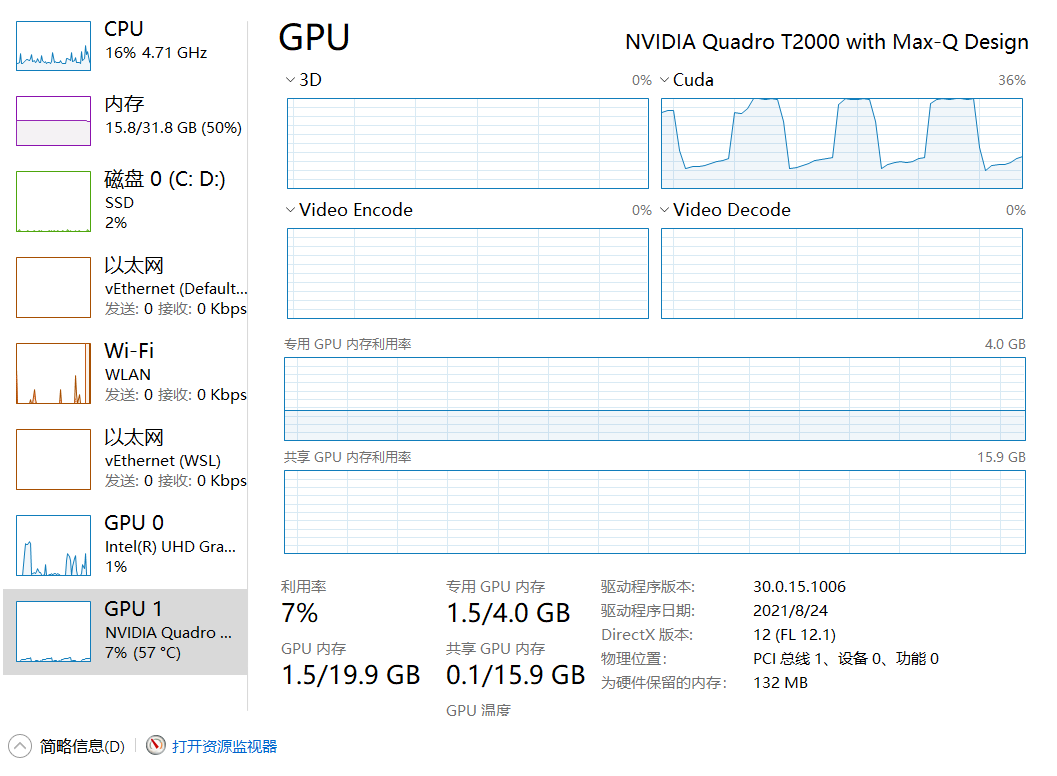

训练过程中，训练集和验证集上的损失函数值与识别准确度的变化图如下：

In [13]:
history_train = pickle.load(open('fashion_history_train.pkl', 'rb'))
history_val = pickle.load(open('fashion_history_val.pkl', 'rb'))

Text(0.5, 1.0, 'Loss vs. No. of epochs')

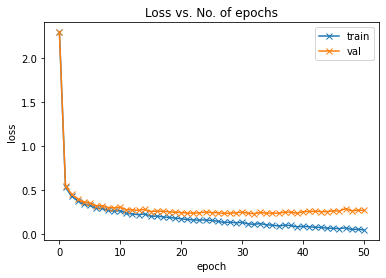

In [14]:
import matplotlib.pyplot as plt

train_losses = [float(x['epoch_loss']) for x in history_train]
val_losses = [float(x['epoch_loss']) for x in history_val]
plt.plot(train_losses, '-x', label='train')
plt.plot(val_losses, '-x', label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs')

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

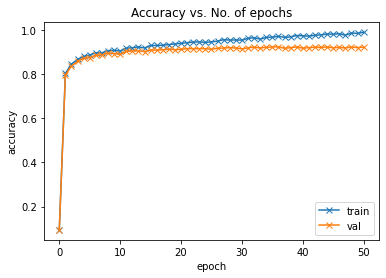

In [15]:
train_accs = [float(x['epoch_acc']) for x in history_train]
val_accs = [float(x['epoch_acc']) for x in history_val]
plt.plot(train_accs, '-x', label='train')
plt.plot(val_accs, '-x', label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy vs. No. of epochs')

训练出来的CNN模型在验证集上的识别准确率为92.12%。从迭代过程中，训练集和验证集上的损失函数与准确度的变化中可以看出，模型在迭代到30步左右时，模型在验证集上的准确率不再上升，并且损失函数值逐渐增大，出现了过拟合的现象。常见的抵抗过拟合的方法由增加数据量、提前停止、Dropout、正则化和标签光滑等。这里，我们使用Dropout技术来抵抗过拟合的问题。Dropout通常是在神经网络隐藏层的部分使用，使用的时候会临时关闭掉一部分的神经元，可通过一个参数来控制神经元关闭的概率。

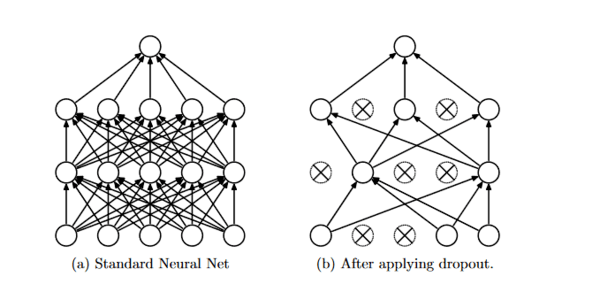

In [16]:
class Fashion_Model2(nn.Module):
  def __init__(self, input_dim, num_classes):
    super().__init__()
    self.input_dim   = input_dim
    self.num_classes = num_classes

    self.network = nn.Sequential(
      nn.Conv2d(input_dim[0], 32, kernel_size=5, stride=1, padding='same'),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),

      nn.Conv2d(32, 64, kernel_size=5, stride=1, padding='same'),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),

      nn.Flatten(),
      nn.Linear(64*(input_dim[1]//4*input_dim[2]//4), 1024),
      nn.ReLU(),
        
      # Dropout
      nn.Dropout(0.5),

      nn.Linear(1024, 10))

  def forward(self, inputs):
    outputs = self.network(inputs)
    return outputs

  @staticmethod
  def compute_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  @staticmethod
  def log_epoch_loss_and_acc(prefix, epoch, epoch_loss, epoch_acc, interval=5):
    if epoch % interval == 0:
      logging.info(f'{prefix}_Epoch [{epoch}], loss: {epoch_loss:.4f},'
                    f' acc: {epoch_acc:.4f}.')

  def evaluate(self, batch, loss_func, need_acc=False, no_grad=False):
    if no_grad:
      with torch.no_grad():
        inputs, labels = batch
        outputs = self(inputs)
        loss = loss_func(outputs, labels)
    else:
      inputs, labels = batch
      outputs = self(inputs)
      loss = loss_func(outputs, labels)

    if need_acc:
      acc  = self.compute_accuracy(outputs, labels)
      return {'loss': loss, 'acc': acc}
    else:
      return {'loss': loss}

  def compute_epoch_loss_and_acc(self, dataloader, loss_func):
    results = [self.evaluate(batch, loss_func, need_acc=True, no_grad=True)
                                    for batch in dataloader]
    batch_losses = [r['loss'] for r in results]
    epoch_loss   = torch.stack(batch_losses).mean()
    batch_accs   = [r['acc'] for r in results]
    epoch_acc    = torch.stack(batch_accs).mean()
    return {'epoch_loss': epoch_loss, 'epoch_acc': epoch_acc}

  def epoch_postprocess(self, prefix, data_loader, epoch,
                        history, loss_func, log_interval):
    loss_and_acc = self.compute_epoch_loss_and_acc(data_loader, loss_func)
    epoch_loss   = loss_and_acc['epoch_loss']
    epoch_acc    = loss_and_acc['epoch_acc']
    history.append({'epoch_loss': epoch_loss,
                    'epoch_acc': epoch_acc})
    self.log_epoch_loss_and_acc(prefix, epoch,
                                     epoch_loss,
                                     epoch_acc,
                                     log_interval)

  def train(self, train_loader, val_loader, num_epochs, lr,
            loss_func=F.cross_entropy, opt_func=torch.optim.Adam,
            log_interval=5):
    optimizer = opt_func(self.parameters(), lr)
    self.history_train = []  # history of train set
    self.history_val   = []  # history of validation set

    # initial loss and accuracy of training dataset
    self.epoch_postprocess('Train', train_loader, 0,
                           self.history_train, loss_func, log_interval)

    # initial loss and accuracy of validation dataset
    self.epoch_postprocess('Val', val_loader, 0,
                           self.history_val, loss_func, log_interval)

    # iteration
    for epoch in range(num_epochs):
      for batch in train_loader:
        loss = self.evaluate(batch, loss_func, need_acc=False)['loss']
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

      # training dataset loss and accuracy
      self.epoch_postprocess('Train', train_loader, epoch+1,
                             self.history_train, loss_func, log_interval)

      # validation dataset loss and accuracy
      self.epoch_postprocess('Val', val_loader, epoch+1,
                             self.history_val, loss_func, log_interval)

  def predict(self, inputs):
    outputs = self(inputs)
    _, preds = torch.max(outputs, dim=1)
    return [preds[i].item() for i in range(len(preds))]

  def save_model(self, save_file):
    torch.save(self.state_dict(), save_file)
    pickle.dump(self.history_train, open('fashion_history_train2.pkl', 'wb'))
    pickle.dump(self.history_val, open('fashion_history_val2.pkl', 'wb'))


  def recover_model(self, save_file):
    self.load_state_dict(torch.load(save_file))
    self.history_train = pickle.load(open('fashion_history_train2.pkl', 'rb'))
    self.history_val   = pickle.load(open('fashion_history_val2.pkl', 'rb'))

In [17]:
# initialize model
logging.info("Initializing ...")
fashion_model2 = Fashion_Model2(inp_dim, out_dim)
# move model parameters to gpu
to_device(fashion_model2, device)
logging.info("Start training...")
fashion_model2.train(train_loader, val_loader, num_epochs,
                    learning_rate, log_interval=5)
logging.info("Training finished.")

fashion_model2.save_model('MNIST2.pth')
logging.info("Save model.")

03/07/2022 01:46:02 PM INFO:Initializing ...
03/07/2022 01:46:02 PM INFO:Start training...
03/07/2022 01:46:11 PM INFO:Train_Epoch [0], loss: 2.3066, acc: 0.0643.
03/07/2022 01:46:12 PM INFO:Val_Epoch [0], loss: 2.3063, acc: 0.0666.
03/07/2022 01:47:31 PM INFO:Train_Epoch [5], loss: 0.3234, acc: 0.8845.
03/07/2022 01:47:33 PM INFO:Val_Epoch [5], loss: 0.3505, acc: 0.8744.
03/07/2022 01:49:01 PM INFO:Train_Epoch [10], loss: 0.2574, acc: 0.9060.
03/07/2022 01:49:03 PM INFO:Val_Epoch [10], loss: 0.2970, acc: 0.8931.
03/07/2022 01:50:31 PM INFO:Train_Epoch [15], loss: 0.2252, acc: 0.9172.
03/07/2022 01:50:32 PM INFO:Val_Epoch [15], loss: 0.2757, acc: 0.9009.
03/07/2022 01:52:00 PM INFO:Train_Epoch [20], loss: 0.1864, acc: 0.9331.
03/07/2022 01:52:02 PM INFO:Val_Epoch [20], loss: 0.2512, acc: 0.9090.
03/07/2022 01:53:24 PM INFO:Train_Epoch [25], loss: 0.1640, acc: 0.9399.
03/07/2022 01:53:25 PM INFO:Val_Epoch [25], loss: 0.2453, acc: 0.9150.
03/07/2022 01:54:46 PM INFO:Train_Epoch [30], los

In [18]:
history_train2 = pickle.load(open('fashion_history_train2.pkl', 'rb'))
history_val2 = pickle.load(open('fashion_history_val2.pkl', 'rb'))

Text(0.5, 1.0, 'Loss vs. No. of epochs')

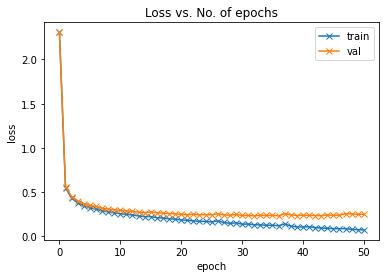

In [19]:
train_losses = [float(x['epoch_loss']) for x in history_train2]
val_losses = [float(x['epoch_loss']) for x in history_val2]
plt.plot(train_losses, '-x', label='train')
plt.plot(val_losses, '-x', label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs')

Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

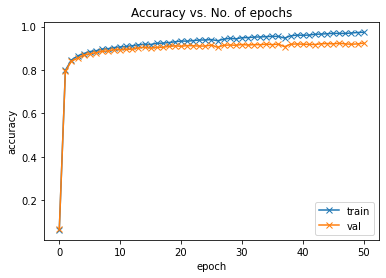

In [20]:
train_accs = [float(x['epoch_acc']) for x in history_train2]
val_accs = [float(x['epoch_acc']) for x in history_val2]
plt.plot(train_accs, '-x', label='train')
plt.plot(val_accs, '-x', label='val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Accuracy vs. No. of epochs')

从迭代过程中输出的损失函数值与识别准确度上可以发现，采用了dropout技术后，过拟合现象略有缓解，在30步后，验证集上的识别准确率还能继续增加，最终验证集上的识别准确率达到了92.41%。

## 5. 测试真实场景下的表现

&ensp;&ensp;&ensp;&ensp;为了验证上述训练模型在真实场景下的表现，我们使用爬虫爬取了京东商城里的相关，并用上述训练好的模型进行识别分类。

使用了Scrapy框架的爬取京东商城图片的爬虫代码如下：

In [23]:
import scrapy

class JDSpider(scrapy.Spider):
  name           = 'JDspider'
  class_name     = '包'
  download_urls  = set()
  max_num        = 100
  start_page_num = 1
  BASE_URL       = f'https://search.jd.com/Search?keyword={class_name}'
  start_urls     = [f'{BASE_URL}&page={start_page_num}']

  custom_settings = {
    'DOWNLOAD_DELAY': 6
  }

  def parse(self, response):
    img_url_list = []
    for product in response.css('li.gl-item img'):
      if len(self.download_urls) < self.max_num and \
                    'data-lazy-img' in product.attrib:
        image_url = 'https:'+product.attrib['data-lazy-img']
        if image_url not in self.download_urls:
          img_url_list.append(image_url)
          self.download_urls.add(image_url)

    yield {'image_urls': img_url_list}

    if len(self.download_urls) < self.max_num:
      self.start_page_num = self.start_page_num + 1
      next_page = f'{self.BASE_URL}&page={self.start_page_num}'
      yield response.follow(next_page, callback=self.parse)

先爬取了100张T-shirt类的商品图片，大致如下所示：

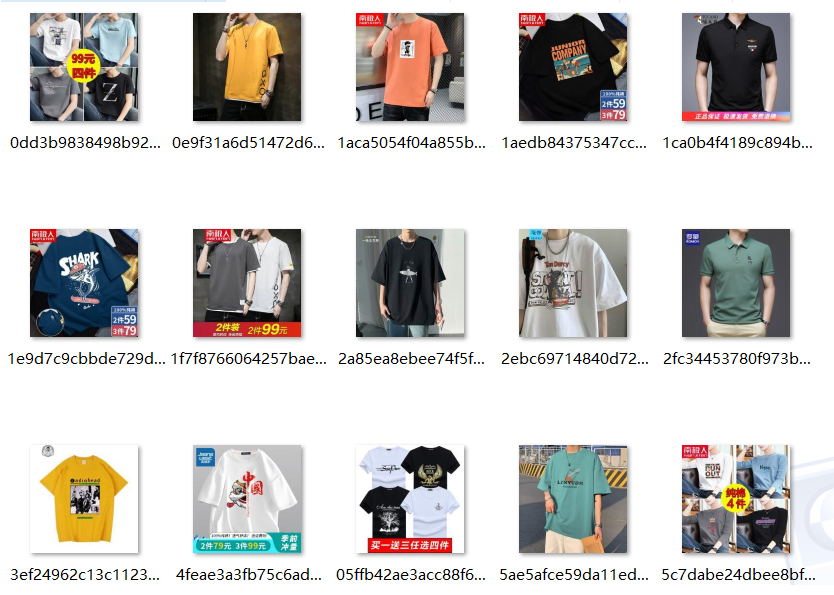

可以看到，京东商城上爬下来的图片与FashionMNIST给的数据集相差还是蛮大的，主要在于京东商城上的图片会出现模特以及其他介绍字样，这都会对最终识别结果造成影响。此外，爬取下来的图片是彩色的，我们需要先将其转换成灰度图片，并且图片的尺寸也要进行一定的缩放。以下面这张图为例：

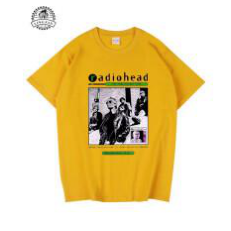

In [47]:
from PIL import Image
import numpy as np
img = Image.open('./codes/JDscraper/JDscraper/T-shirt/full/3ef24962c13c1123b5b338b3aaf62b72d67e5bda.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

转化后：

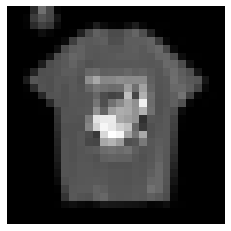

In [48]:
image = np.array(img.resize((28, 28)).convert('L'))
image = (255-image)/255.0
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [49]:
def predict(model, input):
    with torch.no_grad():
        output = model(input)
        poss, pred = torch.max(F.softmax(output, dim=1), dim=1)
    return (pred[0].item(), poss[0].item())

In [51]:
img_tensor = torch.from_numpy(np.array([np.array([image])], dtype="float32"))
device = torch.device('cuda')
img_tensor = img_tensor.cuda()
label, poss = predict(fashion_model2, img_tensor)
print('pred:', label, ', poss:', poss)

pred: 0 , poss: 0.8067902326583862


模型预测值为0，而0对应的正是T-shirt类，该次识别的置信度为80.68%。如果识别得到的置信度小于某个阈值时，我们将其认为不支持的类别。

接着，我们使用有模特和干扰字样的图片进行识别时：

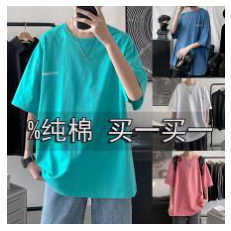

In [52]:
img = Image.open('./codes/JDscraper/JDscraper/T-shirt/full/7cf33d97e051e6100bd37accb2144422da923a08.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

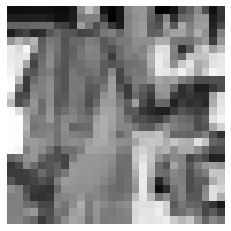

In [53]:
image = np.array(img.resize((28, 28)).convert('L'))
image = (255-image)/255.0
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [54]:
img_tensor = torch.from_numpy(np.array([np.array([image])], dtype="float32"))
device = torch.device('cuda')
img_tensor = img_tensor.cuda()
label, poss = predict(fashion_model2, img_tensor)
print('pred:', label, ', poss:', poss)

pred: 8 , poss: 0.9999761581420898


此时，可以看到，模型将上述图片归类成了bag类，与真实值不符，对100张爬取下来的T-shirt图进行识别时，最终的正确率为

In [59]:
import os
files = os.listdir('./codes/JDscraper/JDscraper/T-shirt/full')
preds = []
for f in files:
    img = Image.open('./codes/JDscraper/JDscraper/T-shirt/full/'+f)
    image = np.array(img.resize((28, 28)).convert('L'))
    image = (255-image)/255.0
    img_tensor = torch.from_numpy(np.array([np.array([image])], dtype="float32"))
    img_tensor = img_tensor.cuda()
    label, poss = predict(fashion_model2, img_tensor)
    preds.append(label)

In [63]:
preds.count(0)/len(preds)

0.13

最终，在爬取下来的T-shirt图片上的识别准确率只有13%。通过浏览京东商城上的商品图，发现bag类的图片相对而言比较纯净，又爬取了100张bag类别的图进行识别。

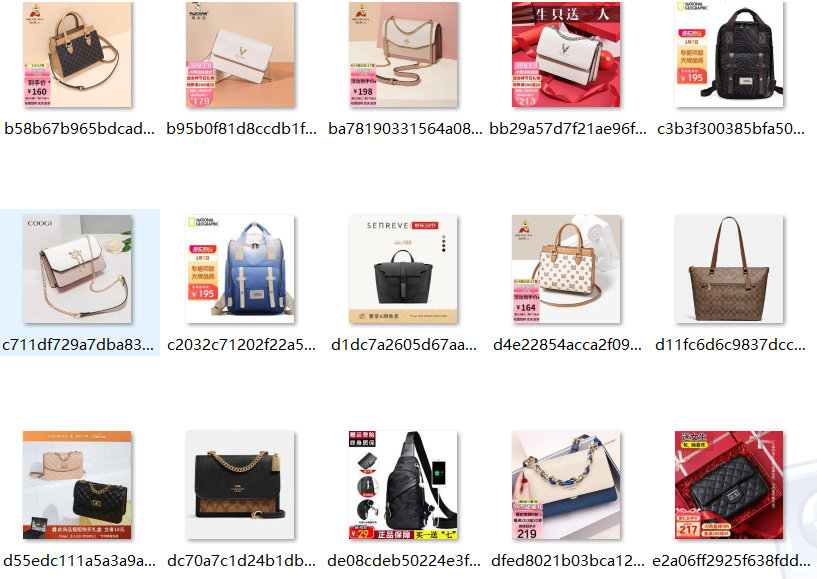

In [64]:
import os
files = os.listdir('./codes/JDscraper/JDscraper/bag/full')
preds = []
for f in files:
    img = Image.open('./codes/JDscraper/JDscraper/bag/full/'+f)
    image = np.array(img.resize((28, 28)).convert('L'))
    image = (255-image)/255.0
    img_tensor = torch.from_numpy(np.array([np.array([image])], dtype="float32"))
    img_tensor = img_tensor.cuda()
    label, poss = predict(fashion_model2, img_tensor)
    preds.append(label)

In [65]:
preds.count(8)/len(preds)

0.81

对爬取下来的bag类别的图的识别准确率能达到81%。可以看出，使用FashionMNIST训练出来的模型的抗干扰能力比较弱，当预测的输入值中存在其他干扰时，对识别准确率影响较大。

## 6. 小结

&ensp;&ensp;&ensp;&ensp;在这次任务中，我学习了卷积神经网络的结构，并通过Pytorch实现，可以看到，使用Pytorch仅需要将全连接神经网络的代码的网络部分稍加修改即可转换成卷积神经网络，开发速度很快。与前2次任务相比，FashionMNIST数据集的输入量较多(28x28)，使用gpu计算加速效果明显。此外，针对训练过程中出现的过拟合现象，使用了Dropout技术进行缓解，进一步提高了模型识别的准确率。在使用训练的模型对真实场景中的图片进行识别的过程中发现，模型的抗干扰能力较弱，只有真实场景中的图片与FashionMNIST数据集中的图片相似时，才能得到一个比较准确的识别结果。